In [4]:
import tensorflow as tf
from models import decoder, encoder, vae, classifier
import pandas as pd
import pathlib
from constants import *
from utils import data_loading
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [5]:
apes_info = pd.read_csv(APES_INFO_FILEPATH)
all_images_ids, train_ids, validation_ids, test_ids = data_loading.get_image_ids(apes_info, pathlib.Path(DATA_FILEPATH))

In [6]:
dataset = data_loading.load_full_dataset(DATA_FILEPATH, IMAGE_SIZE, all_images_ids)

y_train, y_validation, y_test, feature_value_names = data_loading.get_feature_dataset(apes_info, FEATURE_NAMES)

Found 10000 files belonging to 10000 classes.


In [7]:
decoder_model = decoder.build_decoder(LATENT_DIM)
encoder_model = encoder.build_encoder(LATENT_DIM)

vae_model = vae.VAE(encoder_model, decoder_model, RECONSTRUCTION_LOSS_WEIGHT, KL_LOSS_WEIGHT)
vae_model.load_weights(MODEL_VAE_FILEPATH)

# classifier_model = classifier.build_classifier(encoder_model,
#                                                [512, 1024, 2048],
#                                                [0.10, 0.10, 0.10],
#                                                N_UNIQUE_FEATURES, FEATURE_NAMES)

# classifier_model = classifier.build_classifier2(encoder_model)

classifier_model = classifier.build_classifier3()

classifier_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=[tf.keras.losses.BinaryCrossentropy(from_logits=False)] * len(FEATURE_NAMES),
    metrics=["accuracy"],
)

In [ ]:
x_train = data_loading.load_specific_dataset(dataset, train_ids, None)
train_dataset = tf.data.Dataset.zip((x_train, y_train)).batch(BATCH_SIZE)

x_validation = data_loading.load_specific_dataset(dataset, validation_ids, None)
validation_dataset = tf.data.Dataset.zip((x_validation, y_validation)).batch(BATCH_SIZE)

In [379]:
y_train_eyes, y_validation_eyes, y_test_eyes, feature_value_names_eyes = data_loading.get_feature_dataset(
    apes_info, ["Eyes"]
)

y_train_eyes2 = y_train_eyes.map(lambda x: x)
y_validation_eyes2 = y_validation_eyes.map(lambda x: x)

In [380]:
train_dataset_eyes = tf.data.Dataset.zip((x_train, y_train_eyes2)).batch(BATCH_SIZE)
validation_dataset_eyes = tf.data.Dataset.zip((x_validation, y_validation_eyes2)).batch(BATCH_SIZE)

In [279]:
ab = tf.data.Dataset.zip((x_train, y_train_eyes2))

2023-05-30 11:40:29.018530: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype bool and shape [7000,23]
	 [[{{node Placeholder/_12}}]]
2023-05-30 11:40:29.018642: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype bool and shape [7000,23]
	 [[{{node Placeholder/_12}}]]


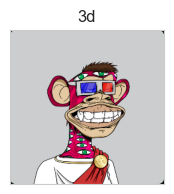

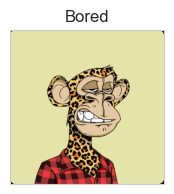

In [280]:
for x, y in ab.take(2):
    plt.figure(figsize=(2, 2))
    plt.title(feature_value_names_eyes["Eyes"][np.argmax(y)])
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [370]:
def build_model_4(out_units):
    inp = tf.keras.layers.Input((256, 256, 3))
    crp = tf.keras.layers.Cropping2D(cropping=((80, 144), (96, 80)))(inp)
    x = encoder.ConvBlock(16, 3)(crp)
    x = encoder.ConvBlock(32, 3)(x)
    x = encoder.ConvBlock(16, 3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = classifier.DenseBlock(32)(x)
    x = classifier.DenseBlock(32)(x)
    x = classifier.DenseBlock(16)(x)
    x = tf.keras.layers.Dense(out_units, activation="sigmoid")(x)
    # return tf.keras.Model(inp, [x, crp])
    return tf.keras.Model(inp, [x])

In [371]:
mdl = build_model_4(23)

mdl.summary()

Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 cropping2d_46 (Cropping2D)  (None, 32, 80, 3)         0         
                                                                 
 conv_block_284 (ConvBlock)  (None, 16, 40, 16)        512       
                                                                 
 conv_block_285 (ConvBlock)  (None, 8, 20, 32)         4768      
                                                                 
 conv_block_286 (ConvBlock)  (None, 4, 10, 16)         4688      
                                                                 
 flatten_67 (Flatten)        (None, 640)               0         
                                                                 
 dense_block_181 (DenseBloc  (None, 32)                206

In [372]:
qw = x_train.take(5)

In [373]:
pr = mdl.predict(qw.batch(32))

1/1 [==============================] - 0s 193ms/step


2023-05-30 11:53:36.609761: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-30 11:53:36.609876: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]


TypeError: Invalid shape () for image data

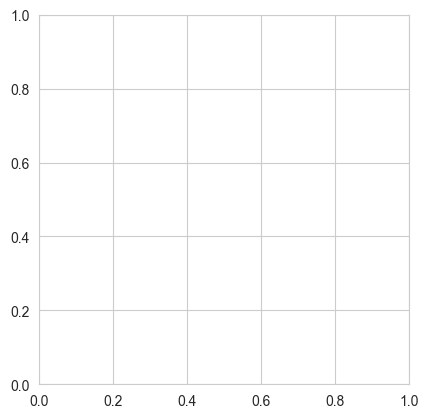

In [374]:
plt.imshow(pr[1][0])

In [375]:
mdl.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=[tf.keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=["accuracy"],
)

In [381]:
mdl.fit(
    train_dataset_eyes.repeat(STEPS_PER_EPOCH * 20),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=20,
    batch_size=None,
    validation_data=validation_dataset_eyes,
)

Epoch 1/20


2023-05-30 12:03:09.773884: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-05-30 12:03:09.774016: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.8432

2023-05-30 12:03:24.456671: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype bool and shape [1500,23]
	 [[{{node Placeholder/_12}}]]
2023-05-30 12:03:24.456799: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype bool and shape [1500,23]
	 [[{{node Placeholder/_12}}]]


54/54 [==============================] - 28s 527ms/step - loss: 0.0479 - accuracy: 0.8432 - val_loss: 0.0202 - val_accuracy: 0.9680
Epoch 2/20
54/54 [==============================] - 28s 520ms/step - loss: 0.0467 - accuracy: 0.8453 - val_loss: 0.0171 - val_accuracy: 0.9680
Epoch 3/20
54/54 [==============================] - 28s 525ms/step - loss: 0.0452 - accuracy: 0.8511 - val_loss: 0.0164 - val_accuracy: 0.9680
Epoch 4/20
54/54 [==============================] - 29s 554ms/step - loss: 0.0452 - accuracy: 0.8513 - val_loss: 0.0165 - val_accuracy: 0.9680
Epoch 5/20
54/54 [==============================] - 31s 580ms/step - loss: 0.0439 - accuracy: 0.8594 - val_loss: 0.0153 - val_accuracy: 0.9680
Epoch 6/20
54/54 [==============================] - 29s 551ms/step - loss: 0.0428 - accuracy: 0.8607 - val_loss: 0.0144 - val_accuracy: 0.9680
Epoch 7/20
54/54 [==============================] - 27s 507ms/step - loss: 0.0428 - accuracy: 0.8604 - val_loss: 0.0144 - val_accuracy: 0.9687
Epoch 8/20

KeyboardInterrupt: 

In [377]:
classifier_model.summary()

Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv_block_5 (ConvBlock)    (None, 128, 128, 32)         1024      ['input_3[0][0]']             
                                                                                                  
 conv_block_18 (ConvBlock)   (None, 128, 128, 16)         512       ['input_3[0][0]']             
                                                                                                  
 conv_block_6 (ConvBlock)    (None, 64, 64, 64)           18752     ['conv_block_5[0][0]']        
                                                                                         

In [10]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CLASSIFIER_FILEPATH,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

csv_logger = tf.keras.callbacks.CSVLogger(HISTORY_CLASSIFIER_FILEPATH, append=True)

In [11]:
history = classifier_model.fit(
    train_dataset.repeat(STEPS_PER_EPOCH * 20),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=20,
    batch_size=None,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint, csv_logger],
)

Epoch 1/20


2023-05-30 08:56:17.450473: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype bool and shape [7000,23]
	 [[{{node Placeholder/_18}}]]
2023-05-30 08:56:17.450655: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype bool and shape [7000,37]
	 [[{{node Placeholder/_16}}]]


54/54 [==============================] - ETA: 0s - loss: 2.4436 - Mouth_loss: 0.2797 - Background_loss: 0.3558 - Hat_loss: 0.6075 - Eyes_loss: 0.3219 - Clothes_loss: 0.2670 - Fur_loss: 0.6116 - Mouth_accuracy: 0.1173 - Background_accuracy: 0.3783 - Hat_accuracy: 0.0334 - Eyes_accuracy: 0.0715 - Clothes_accuracy: 0.0839 - Fur_accuracy: 0.0527

2023-05-30 08:58:22.062464: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-30 08:58:22.062643: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype bool and shape [1500,37]
	 [[{{node Placeholder/_16}}]]


54/54 [==============================] - 143s 3s/step - loss: 2.4436 - Mouth_loss: 0.2797 - Background_loss: 0.3558 - Hat_loss: 0.6075 - Eyes_loss: 0.3219 - Clothes_loss: 0.2670 - Fur_loss: 0.6116 - Mouth_accuracy: 0.1173 - Background_accuracy: 0.3783 - Hat_accuracy: 0.0334 - Eyes_accuracy: 0.0715 - Clothes_accuracy: 0.0839 - Fur_accuracy: 0.0527 - val_loss: 2.5641 - val_Mouth_loss: 0.3330 - val_Background_loss: 0.4563 - val_Hat_loss: 0.5261 - val_Eyes_loss: 0.3698 - val_Clothes_loss: 0.3088 - val_Fur_loss: 0.5700 - val_Mouth_accuracy: 0.2187 - val_Background_accuracy: 0.1167 - val_Hat_accuracy: 0.0393 - val_Eyes_accuracy: 0.1353 - val_Clothes_accuracy: 0.1807 - val_Fur_accuracy: 0.0247
Epoch 2/20
54/54 [==============================] - 133s 2s/step - loss: 1.2316 - Mouth_loss: 0.0932 - Background_loss: 0.1653 - Hat_loss: 0.3393 - Eyes_loss: 0.1508 - Clothes_loss: 0.0877 - Fur_loss: 0.3953 - Mouth_accuracy: 0.4805 - Background_accuracy: 0.7231 - Hat_accuracy: 0.0342 - Eyes_accuracy: 0

KeyboardInterrupt: 

In [10]:
classifier_model.summary()

Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 256),                2201184   ['input_3[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                                  
 concatenate (Concatenate)   (None, 768)                  0         ['encoder[0][0]',             
                                                                     'encoder[0][1]',    

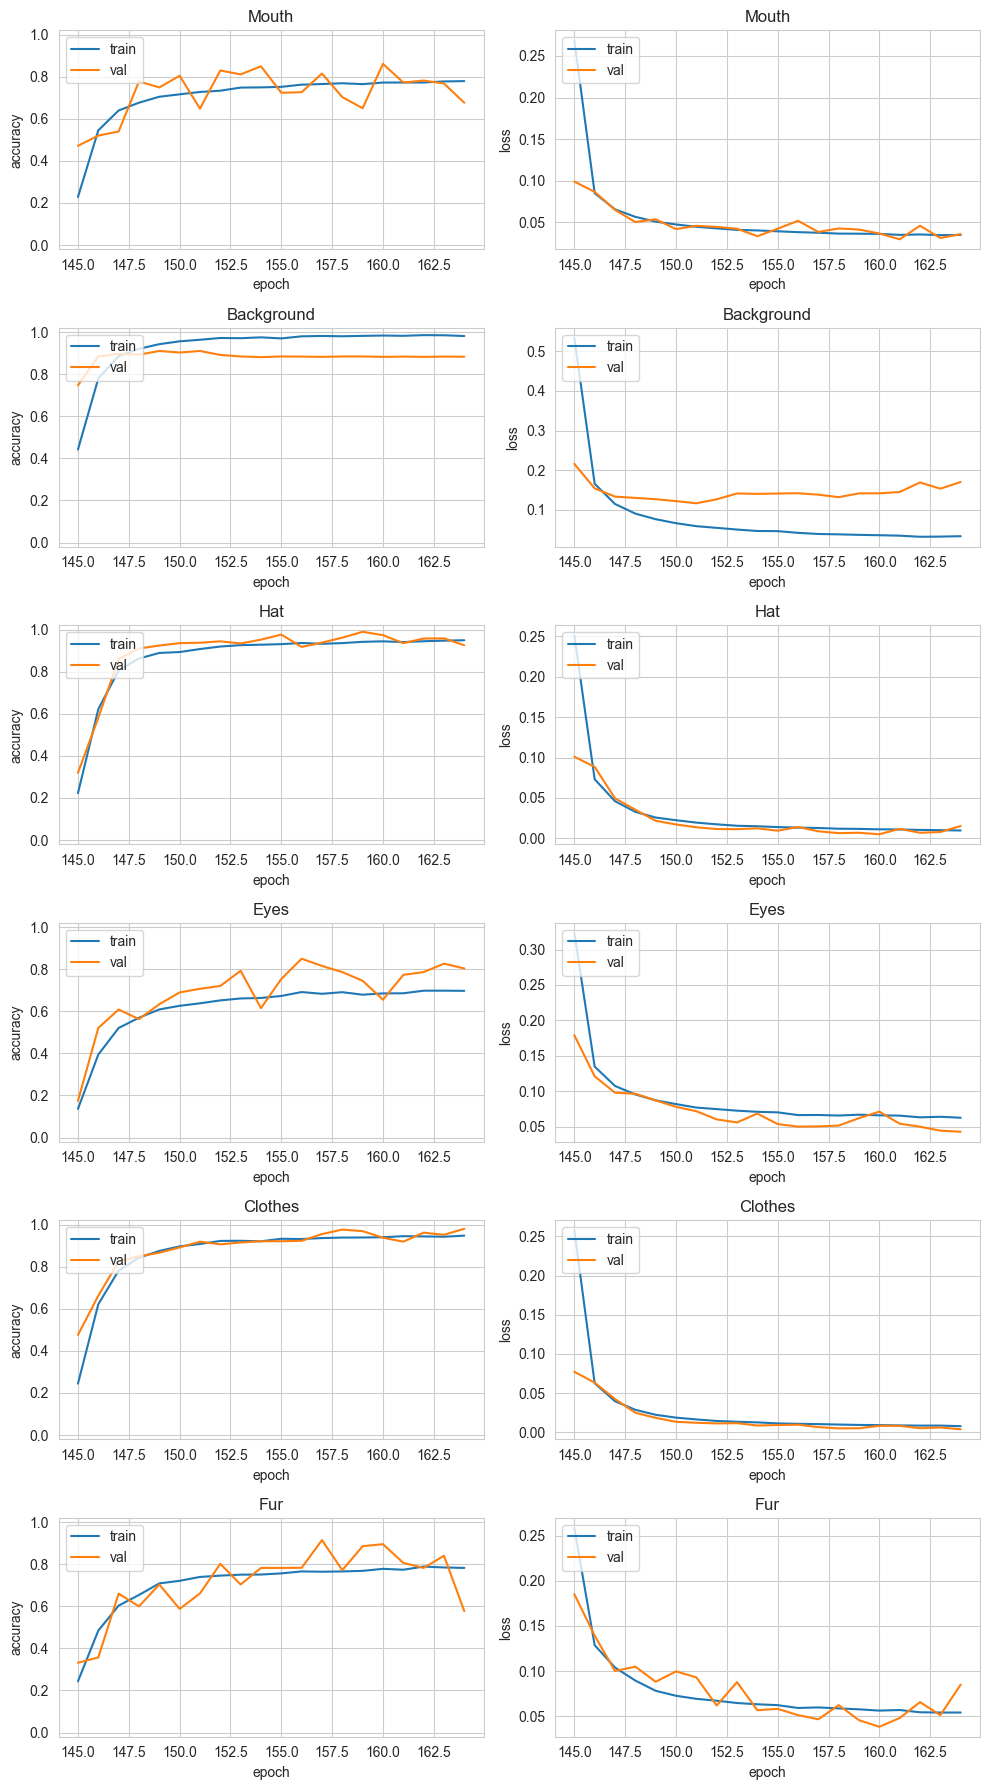

In [9]:
history_classifier_training = pd.read_csv(HISTORY_CLASSIFIER_FILEPATH).iloc[-20:]

plt.figure(figsize=(10, len(FEATURE_NAMES) * 3))

for i, feature_name in enumerate(FEATURE_NAMES):
    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 1)
    plt.plot(history_classifier_training[f"{feature_name}_accuracy"])
    plt.plot(history_classifier_training[f"val_{feature_name}_accuracy"])
    plt.title(feature_name)
    plt.ylim([-0.02, 1.02])
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 2)
    plt.plot(history_classifier_training[f"{feature_name}_loss"])
    plt.plot(history_classifier_training[f"val_{feature_name}_loss"])
    plt.title(feature_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()

In [12]:
abc = classifier_model.predict(validation_dataset)

12/12 [==============================] - 16s 1s/step


In [13]:
classifier_model.summary()

Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 256),                2201184   ['input_3[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                                  
 concatenate (Concatenate)   (None, 768)                  0         ['encoder[0][0]',             
                                                                     'encoder[0][1]',    

In [14]:
a = list(y_validation)

2023-05-30 08:31:44.968467: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype bool and shape [1500,44]
	 [[{{node Placeholder/_8}}]]


In [17]:
apes_info["Eyes"].value_counts()

Eyes
Bored          1714
Bloodshot       846
Sleepy          751
Closed          710
Sad             551
Wide Eyed       549
3d              487
Coins           479
Angry           432
Crazy           407
Heart           394
Sunglasses      352
Robot           350
Eyepatch        333
Zombie          308
Blindfold       264
X Eyes          243
Scumbag         233
Hypnotized      220
Holographic     151
Cyborg          108
Laser Eyes       69
Blue Beams       49
Name: count, dtype: int64

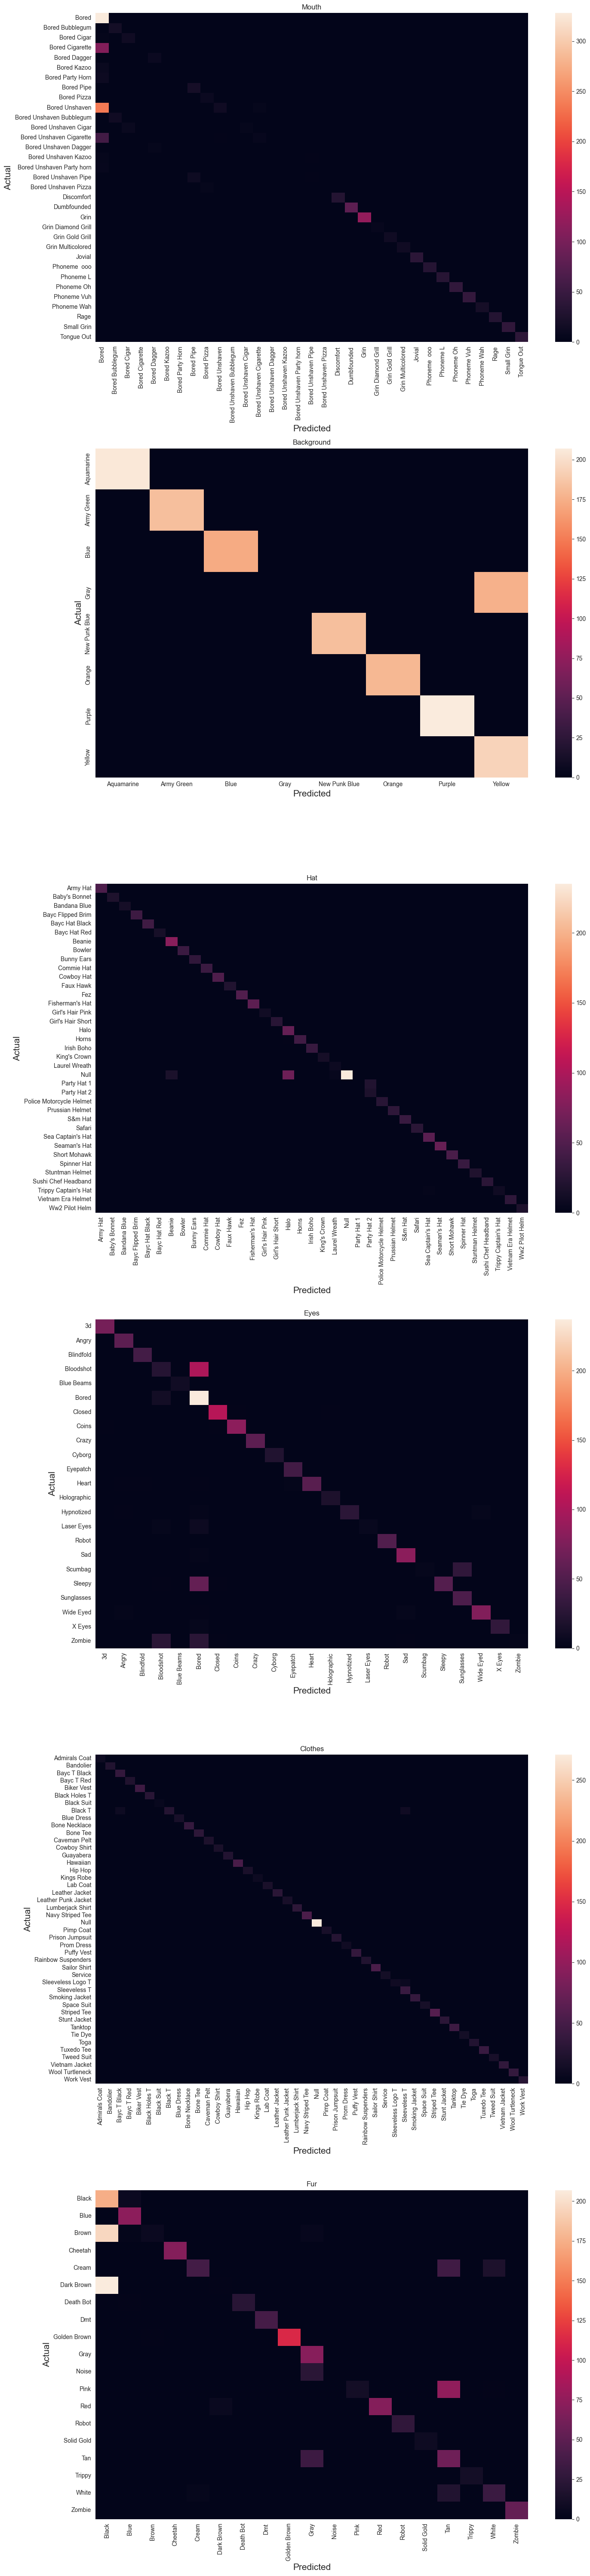

In [15]:
plt.figure(figsize=(15, len(FEATURE_NAMES) * 10))

for i, feature_name in enumerate(FEATURE_NAMES):
    cfm = confusion_matrix(np.argmax([x[i] for x in a], axis=1), np.argmax(abc[i], axis=1))
    df_cm = pd.DataFrame(cfm, index=feature_value_names[feature_name], columns=feature_value_names[feature_name])

    plt.subplot(len(FEATURE_NAMES), 1, i + 1)
    sn.heatmap(df_cm)
    plt.title(feature_name)
    plt.xlabel("Predicted", fontsize=15)
    plt.ylabel("Actual", fontsize=15)

plt.tight_layout()
plt.show()